In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.model_selection import KFold
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append('/home/akumar/nse/neural_control')
from loaders import load_sabes, reach_segment_sabes
from decoders import lr_decoder
from utils import apply_df_filters

#### Consolidate fits on 50 dimensions

In [4]:
# Consolidate 25 ms fits
fls = glob.glob('/mnt/Secondary/data/mpi_cc50cv_all/*.pkl')
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break
df = pd.DataFrame(rl)
# Filter out erroneous data_file
df = apply_df_filters(df, fl=['/mnt/Secondary/data/sabes_tmp50/indy_20160426_01.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170210_03.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170213_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170214_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170215_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170216_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170217_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170227_04.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170228_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170301_05.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170302_02.pkl'])

In [5]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50_cvall.dat', 'wb') as f:
    f.write(pickle.dumps(df))

In [5]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 50))
r2_scores = np.zeros(df.shape[0])

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    fold_idx = df.iloc[i]['fold_idx']
    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[fold_idx]

    x = X[train_idxs]
    y = Y[train_idxs]

    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


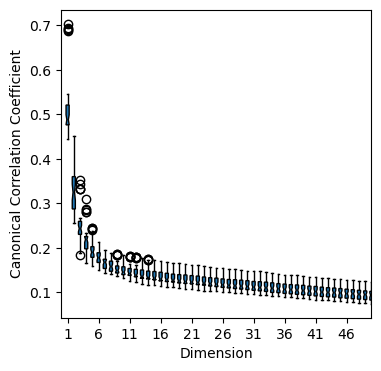

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))

#ax.errorbar(np.arange(50), np.mean(cc_coefs, axis=0), yerr=np.std(cc_coefs, axis=0))
medianprops = dict(linewidth=0)
bplot = ax.boxplot(np.reshape(cc_coefs, (-1, 50)), patch_artist=True, medianprops=medianprops, notch=True)
ax.set_xticks(np.arange(1, 51, 5))
ax.set_xticklabels(np.arange(1, 51, 5))
ax.set_xlim([0, 50])
ax.set_ylabel('Canonical Correlation Coefficient')
ax.set_xlabel('Dimension')
fig.savefig('/home/akumar/nse/neural_control/figs/cca/cc_coefs.pdf', bbox_inches='tight', pad_inches=0)

In [17]:
df['cc_coefs'] = list(cc_coefs)

### CCA dimension selection via Information criteria

In [18]:
# p <= q
def CC_AIC(cc_coefs, N, p, q):
    # Sort in descending order
    cc_coefs = np.sort(cc_coefs)[::-1]

    # Calculate the vector Ak
    Ak = np.array([-N * np.sum(np.log(1 - np.power(cc_coefs[k + 1:], 2))) -2 * (p - k) * (q - k) for k in range(cc_coefs.size - 1)])
    return Ak

def CC_BIC(cc_coefs, N, p, q):
    # Sort in descending order
    cc_coefs = np.sort(cc_coefs)[::-1]

    # Calculate the vector Ak
    Ak = np.array([-N * np.sum(np.log(1 - np.power(cc_coefs[k + 1:], 2))) -np.log(N) * (p - k) * (q - k) for k in range(cc_coefs.size - 1)])
    return Ak

In [19]:
cc_dim = np.zeros((df.shape[0], 2))

for i in range(df.shape[0]):
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    fold_idx = df.iloc[i]['fold_idx']
    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[fold_idx]

    X = X[train_idxs]
    Y = Y[train_idxs]

    p = min(X.shape[1], Y.shape[1])
    q = max(X.shape[1], Y.shape[1])

    Ak = CC_AIC(df.iloc[i]['cc_coefs'], X.shape[0], p, q)
    cc_dim[i, 0] = np.argmin(Ak)
    Ak = CC_BIC(df.iloc[i]['cc_coefs'], X.shape[0], p, q)    
    cc_dim[i, 1] = np.argmin(Ak)

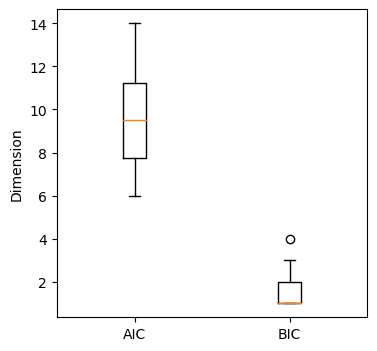

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot(cc_dim + 1)
ax.set_xticklabels(['AIC', 'BIC'])
ax.set_ylabel('Dimension')
fig.savefig('/home/akumar/nse/neural_control/figs/cca/dim_selection.pdf', bbox_inches='tight', pad_inches=0)

In [27]:
# Calculate the fraction of variance captured by successive CCA dimensions
var_frac = np.zeros((df.shape[0], 50, 2))
var_frac_pca = np.zeros((df.shape[0], 50, 2))

for i in range(df.shape[0]):
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    fold_idx = df.iloc[i]['fold_idx']
    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[fold_idx]

    X = X[train_idxs]
    Y = Y[train_idxs]
    
    covX = np.cov(X, rowvar=False)
    covY = np.cov(Y, rowvar=False)


    eigX = np.linalg.eigvals(covX)
    eigX = np.sort(eigX)[::-1]
    eigY = np.linalg.eigvals(covY)
    eigY = np.sort(eigY)[::-1]

    tot_varX = np.trace(covX)
    tot_varY = np.trace(covY)

    model = df.iloc[i]['ccamodel']
    xcoef = model.x_rotations_
    ycoef = model.y_rotations_

    for j in range(1, 51):
        x_c = X @ xcoef[:, 0:j]
        y_c = Y @ ycoef[:, 0:j]
        if j == 1:  
            var_frac[i, j - 1, 0] = np.var(x_c)/tot_varX
            var_frac[i, j - 1, 1] = np.var(y_c)/tot_varY
        else:
            var_frac[i, j - 1, 0] = np.trace(np.cov(x_c, rowvar=False))/tot_varX
            var_frac[i, j - 1, 1] = np.trace(np.cov(y_c, rowvar=False))/tot_varY

        var_frac_pca[i, j - 1, 0] = np.sum(eigX[0:j])/tot_varX
        var_frac_pca[i, j - 1, 1] = np.sum(eigY[0:j])/tot_varY

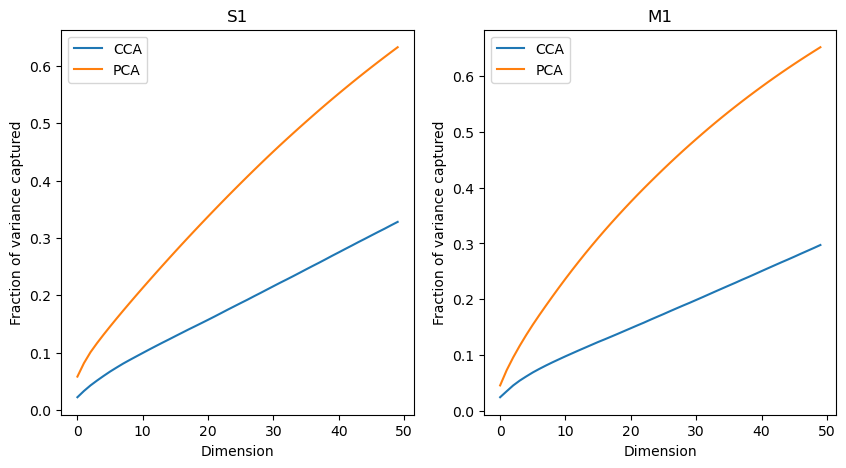

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.mean(var_frac[..., 0], axis=0))
ax[0].plot(np.mean(var_frac_pca[..., 0], axis=0))
ax[0].set_title('S1')
ax[0].set_xlabel('Dimension')
ax[0].set_ylabel('Fraction of variance captured')
ax[0].legend(['CCA', 'PCA'])

ax[1].set_title('M1')
ax[1].plot(np.mean(var_frac[..., 1], axis=0))
ax[1].plot(np.mean(var_frac_pca[..., 1], axis=0))
ax[1].legend(['CCA', 'PCA'])
ax[1].set_xlabel('Dimension')
ax[1].set_ylabel('Fraction of variance captured')

fig.savefig('/home/akumar/nse/neural_control/figs/cca/cca_var_explained.pdf', bbox_inches='tight', pad_inches=0)